# 第五章 工具使用和国际象棋

## 一、基础配置

In [9]:
from utils import get_openai_api_key, get_openai_base_url
OPENAI_API_KEY = get_openai_api_key()
OPENAI_BASE_URL = get_openai_base_url()
llm_config = {"model": "gpt-4o"}

In [10]:
import chess
import chess.svg
from typing_extensions import Annotated

## 二、初始化国际象棋棋盘

In [11]:
board = chess.Board()

In [12]:
made_move = False

## 三、定义需要的工具

### 3.1 获取合规行动的工具

In [13]:
def get_legal_moves(
    
) -> Annotated[str, "UCI格式的合法移动列表"]:
    return "可以采取的移动方式如下: " + ",".join(
        [str(move) for move in board.legal_moves]
    )

### 3.2 在棋盘上行动一步的工具

In [14]:
def make_move(
    move: Annotated[str, "一次UCI格式的移动"]
) -> Annotated[str, "移动的结果"]:
    move = chess.Move.from_uci(move)
    board.push_uci(str(move))
    global made_move
    made_move = True
    
    # 可视化棋盘
    display(
        chess.svg.board(
            board,
            arrows=[(move.from_square, move.to_square)],
            fill={move.from_square: "gray"},
            size=200
        )
    )
    
    # 获取棋子的名称
    piece = board.piece_at(move.to_square)
    piece_symbol = piece.unicode_symbol()
    piece_name = (
        chess.piece_name(piece.piece_type).capitalize()
        if piece_symbol.isupper()
        else chess.piece_name(piece.piece_type)
    )
    return f"Moved {piece_name} ({piece_symbol}) from "\
    f"{chess.SQUARE_NAMES[move.from_square]} to "\
    f"{chess.SQUARE_NAMES[move.to_square]}."

`UCI`, 即`Universal Chess Interface`格式是国际象棋引擎与界面之间进行通信的标准化协议。</br>
它由`Chess Engine Communication Protocol,CECP`发展而来，并被广泛用于现代国际象棋软件中。</br>
使用UCI格式可以确保不同国际象棋程序间的兼容性和互操作性。

`UCI`格式的主要用途包括：

1. **走子描述**：提供一种标准的方式来表示棋盘上的位置和棋子的移动。例如，`e2e4`表示从位置`e2`到`e4`的移动。

2. **命令接口**：允许用户或程序与棋弈引擎进行交互，如搜索选项设置、局面分析等。

3. **棋局导入/导出**：支持将棋局保存为文本格式，方便在不同的程序间传输。

在上述代码中，`chess.Move.from_uci(move)`函数用于将`UCI`格式的字符串转换为一个内部表示的`Move`对象。这种转换使得程序能够理解用户的走子意图，并在棋盘上执行相应的操作。


## 四、创建智能体

接下来，我们将在棋盘上创建两个玩家智能体和一个象棋裁判智能体。

In [15]:
from autogen import ConversableAgent

In [16]:
# 白色方智能体
player_white = ConversableAgent(
    name="白方",
    system_message="你是一名国际象棋手，你是白方。 "
    "首先调用 get_legal_moves(), 来获取合法移动列表。 "
    "首先调用 get_legal_moves(), 来获取合法移动列表。 ",
    llm_config=llm_config,
)

In [17]:
# 黑色方智能体
player_black = ConversableAgent(
    name="黑方",
    system_message="你是一名国际象棋手，你是黑方。 "
    "首先调用 get_legal_moves(), 来获取合法移动列表。 "
    "首先调用 get_legal_moves(), 来获取合法移动列表。 ",
    llm_config=llm_config,
)

In [18]:
def check_made_move(msg):
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False


In [19]:
board_proxy = ConversableAgent(
    name="棋局裁判",
    llm_config=False,
    is_termination_msg=check_made_move,
    default_auto_reply="请执行一次移动。",
    human_input_mode="NEVER",
)

## 五、注册工具

工具需要被注册后才能被智能体调用或执行

In [20]:
from autogen import register_function

In [21]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )
    
    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

In [22]:
player_black.llm_config["tools"]

[{'type': 'function',
  'function': {'description': 'Get legal moves.',
   'name': 'get_legal_moves',
   'parameters': {'type': 'object', 'properties': {}, 'required': []}}},
 {'type': 'function',
  'function': {'description': 'Call this tool to make a move.',
   'name': 'make_move',
   'parameters': {'type': 'object',
    'properties': {'move': {'type': 'string', 'description': '一次UCI格式的移动'}},
    'required': ['move']}}}]

## 六、嵌套交互注册

每个玩家智能体都将与象棋裁判智能体进行嵌套交互，从而在棋盘上执行移动。

In [23]:
player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
        }
    ],
)

## 七、开始游戏

棋局游戏将从第一条消息开始。

<p style="background-color:#ECECEC; padding:15px; "> <b>注意1：</b>对于本课程的代码实践，推荐使用gpt-4-turbo或gpt-4o来获得更好的结果。</br><b>注意2：</b>每次实验结果的玩家的棋子移动都可能略有不同。因为这和大语言模型的底层逻辑，预测下一个生成token的最大概率有关。</p>

黑方 (to 白方):

让我们开始国际象棋吧。先是你的移动回合。

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
棋局裁判 (to 白方):

让我们开始国际象棋吧。先是你的移动回合。

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
白方 (to 棋局裁判):

***** Suggested tool call (call_GDh7J7TyaVbdj7X9AagyO9b2): get_legal_moves *****
Arguments: 
{}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
棋局裁判 (to 白方):

棋局裁判 (to 白方):

***** Response from calling tool (call_GDh7J7TyaVbdj7X9AagyO9b2) *****
可以采取的移动方式如下: g1h3,g1f3,b1c3,b1a3,h2h3,g2g3,f2f3,e2e3,d2d3,c2c3,b2b3,a2a3,h2h4,g2g4,f2f4,e2e4,d2

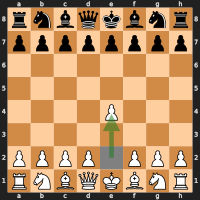

棋局裁判 (to 白方):

棋局裁判 (to 白方):

***** Response from calling tool (call_Xu3l9aeb58FuZUM0LGYAIbyf) *****
Moved pawn (♙) from e2 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
白方 (to 棋局裁判):

我已经把兵从e2移动到了e4。现在轮到你的回合了。

--------------------------------------------------------------------------------
白方 (to 黑方):

我已经把兵从e2移动到了e4。现在轮到你的回合了。

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
棋局裁判 (to 黑方):

我已经把兵从e2移动到了e4。现在轮到你的回合了。

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
黑方 (to 棋局裁判):

***** Suggested tool call (call_QvP8JTQgmwEPEoAR41HsT4WO

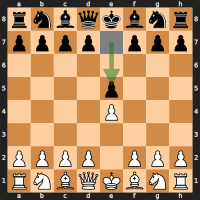

棋局裁判 (to 黑方):

棋局裁判 (to 黑方):

***** Response from calling tool (call_XXJCfHSWCUaoH6yu3pJYVr75) *****
Moved pawn (♟) from e7 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
黑方 (to 棋局裁判):

我已经移动了我的兵从e7到e5。轮到你了。

--------------------------------------------------------------------------------
黑方 (to 白方):

我已经移动了我的兵从e7到e5。轮到你了。

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
棋局裁判 (to 白方):

我已经移动了我的兵从e7到e5。轮到你了。

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
白方 (to 棋局裁判):

***** Suggested tool call (call_88FEFpwX5rkDpPT9GKM0Qowd): get_legal

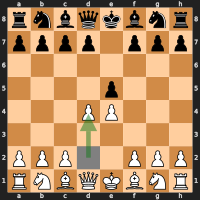

棋局裁判 (to 白方):

棋局裁判 (to 白方):

***** Response from calling tool (call_X67CBg3scS5KtmuH0wi1XWNE) *****
Moved pawn (♙) from d2 to d4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
白方 (to 棋局裁判):

我已经将兵从d2移动到d4。轮到你了。

--------------------------------------------------------------------------------
白方 (to 黑方):

我已经将兵从d2移动到d4。轮到你了。

--------------------------------------------------------------------------------


In [24]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="让我们开始国际象棋吧。先是你的移动回合。",
    max_turns=2,
)

## 八、为游戏过程添加一些有趣的闲聊

In [25]:
player_white = ConversableAgent(
    name="Player White",
    system_message="你是一名国际象棋手，你是白方。 "
    "首先调用 get_legal_moves(), 来获取合法移动列表。 "
    "首先调用 get_legal_moves(), 来获取合法移动列表。 "
    "移动执行之后，进行闲聊来让游戏变得有趣。",
    llm_config=llm_config,
)

In [26]:
player_black = ConversableAgent(
    name="Player Black",
    system_message="你是一名国际象棋手，你是白方。 "
    "首先调用 get_legal_moves(), 来获取合法移动列表。 "
    "首先调用 get_legal_moves(), 来获取合法移动列表。 "
    "移动执行之后，进行闲聊来让游戏变得有趣。",
    llm_config=llm_config,
)

In [27]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )

    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

Player Black (to Player White):

让我们开始国际象棋吧。先是你的移动回合。

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


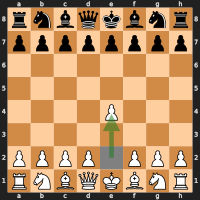


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

好的，我已经将我的兵从 e2 移动到 e4 了。现在轮到你了。

你喜欢国际象棋的什么部分？是策略规划还是精彩战术？

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


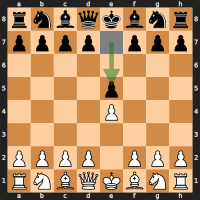


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

轮到你了！

至于你的问题，我觉得国际象棋的每个部分都有它的魅力。策略规划让我感觉像是在运筹帷幄，而精彩的战术则是智慧的较量，它们都有自己的乐趣。你更喜欢哪一部分呢？

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


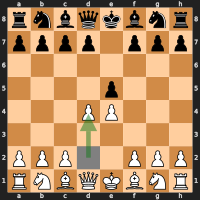


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

我已经将兵从d2移动到d4。接下来轮到你了！

至于刚才的问题，作为棋手，我对策略规划和战术都非常感兴趣。策略规划让我感到在策划一个大局，而战术细节则是每一步都是智力的较量。你更喜欢哪一部分呢？

--------------------------------------------------------------------------------


In [28]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="让我们开始国际象棋吧。先是你的移动回合。",
    max_turns=2,
)

**注意：**
如果要为游戏添加人为输入，请为两个玩家智能体添加参数 **`human_input_mode="ALWAYS"`**。